<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose


## Подготовка

In [2]:
# считаем данные и загрузим в датафрейм
taxi_data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# отсортируем данные по индексу
taxi_data.sort_index(inplace=True)

In [4]:
# проверим данные на пропуски
taxi_data.isna().sum()

num_orders    0
dtype: int64

In [5]:
# проверим данные на монотонность
taxi_data.index.is_monotonic

True

In [6]:
# ресемплируем данные по часу
taxi_data = taxi_data.resample('1H').sum()

In [7]:
# выведем общее инфо о датасете
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Вывод 
Загруженные данные подготовили для последующего анализа. Ресемплировали данные по часу, не обнаружены пропуски в данных. Для анализа предоставлен период с марта по август 2018 года 

## Анализ

In [8]:
# скопируем данные в отдельный датасет для анализа
data = taxi_data.copy()

<AxesSubplot:xlabel='datetime'>

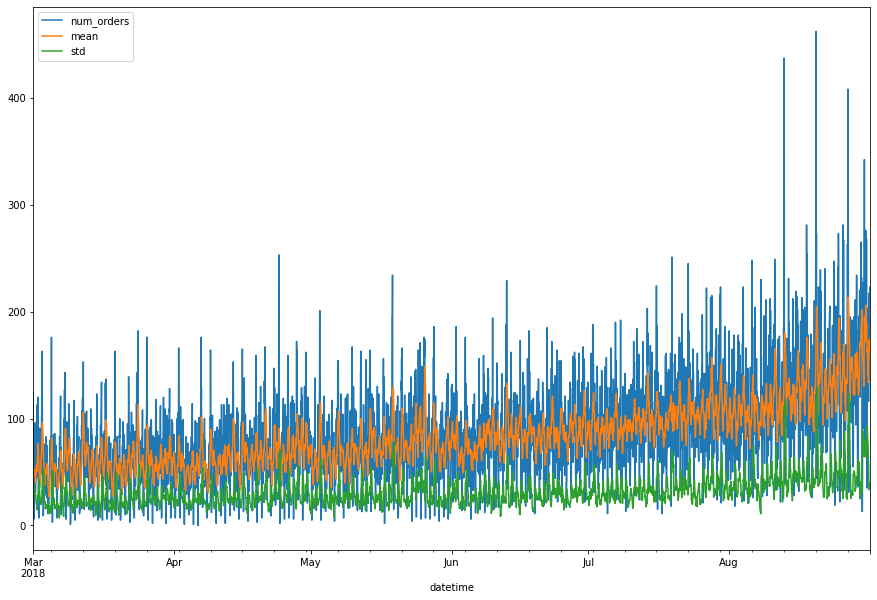

In [9]:
# построим графики скользящего среднего и скользящего стандартного отклонения
data['mean'] = data['num_orders'].rolling(10).mean()
data['std'] = data['num_orders'].rolling(10).std()
data.plot(figsize=(15,10))

Разделим данные на тренд, сезонность и шумы

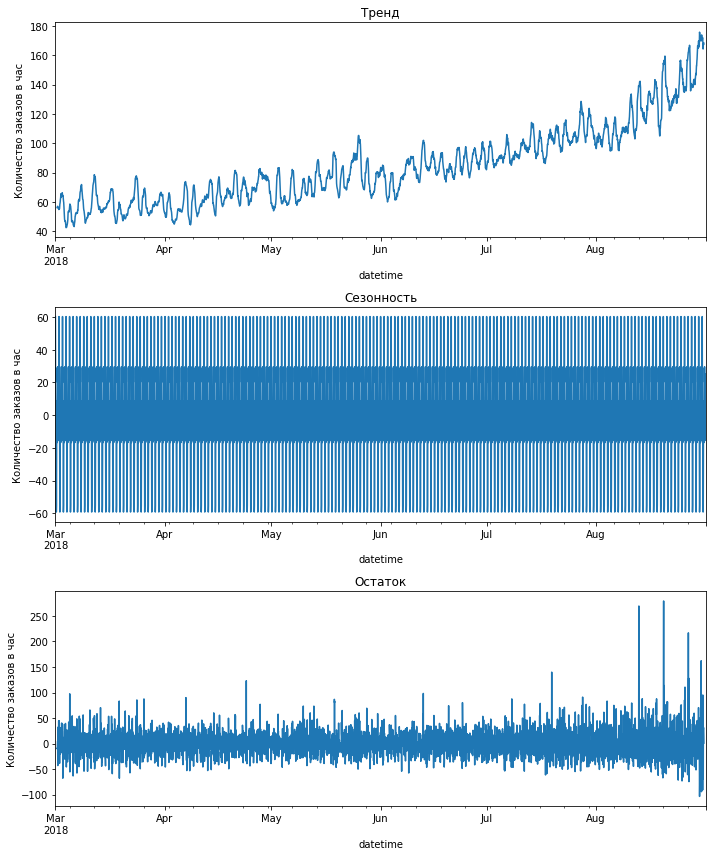

In [10]:
decomposed = seasonal_decompose(taxi_data)

plt.figure(figsize=(10, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel('Количество заказов в час')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel('Количество заказов в час')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.ylabel('Количество заказов в час')

plt.tight_layout()


По графику сезонности нет понимания о периодичности - построим графики с меньшим срезом

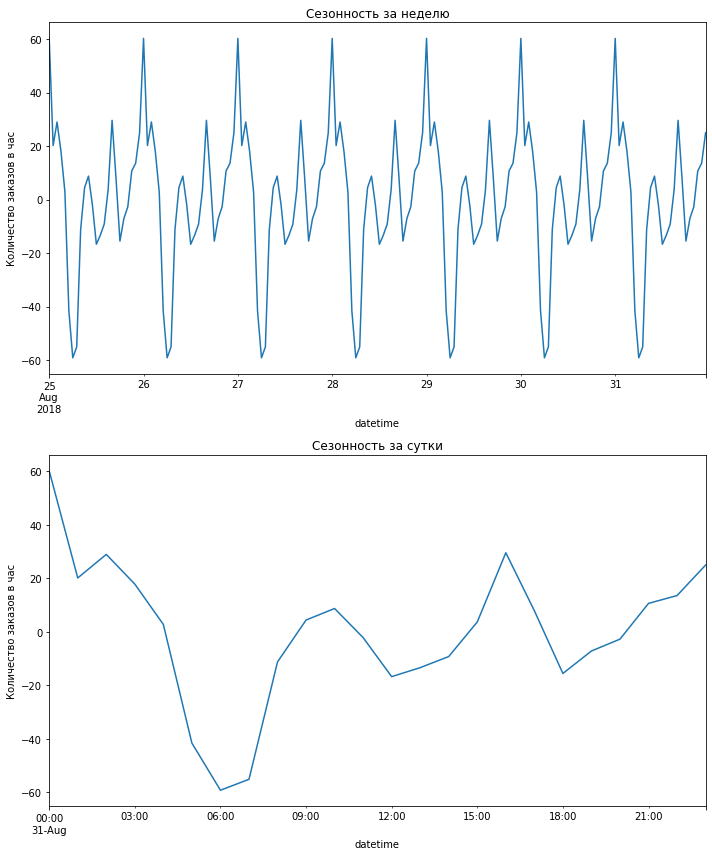

In [11]:
plt.figure(figsize=(10, 12))

plt.subplot(211)
decomposed.seasonal.tail(24*7).plot(ax=plt.gca())
plt.title('Сезонность за неделю')
plt.ylabel('Количество заказов в час')

plt.subplot(212)
decomposed.seasonal.tail(24*1).plot(ax=plt.gca())
plt.title('Сезонность за сутки')
plt.ylabel('Количество заказов в час')

plt.tight_layout()

Наблюдаем положительный тренд в течение полугода. Сезонность с периодичностью в сутки с пиком ночью и после обеда, спадом в утреннее время.

## Обучение

Создадим признаки для горизонта прогнозирования с помощью функции

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [13]:
RANDOM_STATE=42

make_features(taxi_data, 12, 24)

train, test = train_test_split(taxi_data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']


In [14]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_train)

print("RMSE обучающей выборки:", mean_squared_error(y_train, pred_lr, squared=False))

RMSE обучающей выборки: 30.23528245165893


In [15]:
rmse_lr = mean_squared_error(y_train, pred_lr, squared=False)

In [16]:
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [17]:
#создадим подбор гиперпараметров для модели
parameters_dtr = {
    'min_samples_leaf': range(1, 6),
    'max_depth': range(1, 9)
}

In [18]:
tscv=TimeSeriesSplit(n_splits = 5)

In [19]:
gs_dt = GridSearchCV(
    model_dtr,
    parameters_dtr,
    n_jobs=-1,
    cv=tscv,
    scoring='neg_root_mean_squared_error'
)

gs_dt.fit(X_train, y_train) 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 9),
                         'min_samples_leaf': range(1, 6)},
             scoring='neg_root_mean_squared_error')

In [20]:
print('Лучшие параметры модели:\n', gs_dt.best_params_)

Лучшие параметры модели:
 {'max_depth': 8, 'min_samples_leaf': 5}


In [21]:
print ('Метрика модели на тренировочной выборке:', -gs_dt.best_score_)

Метрика модели на тренировочной выборке: 28.81756637417852


In [22]:
rmse_dtr = -gs_dt.best_score_

In [23]:
model_lgbmr = LGBMRegressor(random_state=RANDOM_STATE) 

In [24]:
#подбор гиперпараметров
parameters_lgbm = {
    'num_leaves':[100, 150], 
    'n_estimators': [100, 500], 
    'learning_rate':[0.1, 0.5]
}

In [25]:
gd_lgbm = GridSearchCV(
    model_lgbmr, 
    parameters_lgbm, 
    n_jobs=-1,
    cv=tscv, 
    scoring='neg_root_mean_squared_error'
)

gd_lgbm.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5],
                         'n_estimators': [100, 500], 'num_leaves': [100, 150]},
             scoring='neg_root_mean_squared_error')

In [26]:
print('Лучшие параметры модели:\n', gd_lgbm.best_params_)

Лучшие параметры модели:
 {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 100}


In [27]:
print ('Метрика модели на тренировочной выборке:', -gd_lgbm.best_score_)

Метрика модели на тренировочной выборке: 25.387798008494322


In [28]:
rmse_lgbm = - gd_lgbm.best_score_

### Вывод
Обучили три модели с подбором гиперпараметров с помощью  GridSearchCV. 
Получили значение RMSE на тренировочной выборке:
- LinearRegression - 30.24
- DecisionTreeRegressor - 28.82
- LightGBM - 25.39 

Лучший показатель у модели LightGBM  

## Тестирование

Проверим данные на тестовой выборке с помощью подобранных гиперпараметров

In [29]:
#предсказания на тестовой выборке линейной регрессии
pred_lr_test = model_lr.predict(X_test)
rmse_lr_test = mean_squared_error(pred_lr_test, y_test, squared=False)

In [30]:
#предсказания на тестовой выборке модели дерева решений
model_dtr = DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 5, random_state=RANDOM_STATE)
model_dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=5, random_state=42)

In [31]:
pred_dtr_test = model_dtr.predict(X_test)
rmse_dtr_test = mean_squared_error(pred_dtr_test, y_test, squared=False)

In [32]:
#предсказания на тестовой выборке LightGBM
model_lgbm = LGBMRegressor(n_estimators=100, num_leaves=100, learning_rate=0.1,random_state=RANDOM_STATE) 
model_lgbm.fit(X_train, y_train)

LGBMRegressor(num_leaves=100, random_state=42)

In [33]:
preds_lgbm_test = model_lgbm.predict(X_test)
rmse_lgbm_test = mean_squared_error(preds_lgbm_test, y_test, squared=False)

In [34]:
data = {'RMSE на тренировочной выборке':
        [
            rmse_lr,
            rmse_dtr,
            rmse_lgbm           
        ],

        'RMSE на тестовой выборке':
        [
            rmse_lr_test,
            rmse_dtr_test,
            rmse_lgbm_test   
        ]
       }
index = ['LinearRegressor',
         'DecisionTreeRegressor',
         'LGBMRegressor'
        ]


qualities = pd.DataFrame(data=data, index=index)
print(qualities)

                       RMSE на тренировочной выборке  RMSE на тестовой выборке
LinearRegressor                            30.235282                 50.208266
DecisionTreeRegressor                      28.817566                 48.658009
LGBMRegressor                              25.387798                 42.965762


Лучший показатель на тестовых данных снова у модели LightGBM - 42.97

## Вывод

В ходе проекта решали задачу по построению модели для прогноза количества заказов на следующий час. 
При анализе данных пронаблюдали положительный тренд в течение полугода. Сезонность с периодичностью в сутки с пиком ночью и после обеда, спадом в утреннее время.

Лучшие показатели на тренировочной и тестовой выборке показала модель LightGBM - 25.39 и                 42.97 соответственно. 